In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
from typing import Callable, Optional, Union

import gymnasium as gym
import ray
from ray import tune
from ray.air import session
from ray.rllib.algorithms import ppo, AlgorithmConfig
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env

from sustaingym.envs.evcharging import EVChargingEnv, RealTraceGenerator, GMMsTraceGenerator, DiscreteActionWrapper, MultiAgentEVChargingEnv
from sustaingym.envs.evcharging.event_generation import AbstractTraceGenerator
from sustaingym.envs.evcharging.utils import \
    DATE_FORMAT, DEFAULT_PERIOD_TO_RANGE, DATE_FORMAT, SiteStr


###
NUM_SUBPROCESSES = 4
TIMESTEPS = 250_000
EVAL_FREQ = 10_000
SAMPLE_EVAL_PERIODS = {
    'Summer 2019':   ('2019-07-01', '2019-07-14'),
    'Fall 2019':     ('2019-11-04', '2019-11-17'),
    'Spring 2020':   ('2020-04-06', '2020-04-19'),
    'Summer 2021':   ('2021-07-05', '2021-07-18'),
}

def get_env(full: bool, real_trace: bool, dp: str, site: SiteStr, discrete: bool = False,
            multiagent: bool = True, periods_delay: int = 0, seed: int= None) -> Callable:
    """Return environment.

    Args:
        full: if True, use full season; otherwise, use sample 2 weeks
        real_trace: choice of generator
        dp: 'Summer 2019', 'Fall 2019', 'Spring 2020', 'Summer 2021'
        site: 'caltech' or 'jpl'
        discrete: whether to wrap environment in discrete action wrapper
        seed: seed for GMMs generator
        multiagent: if True, return multi-agent environment. Note
            discrete = True and multiagent = True is currently not
            supported.
        periods_delay: number of timesteps for communication delay in
            the multiagent setting, ignored if multiagent = False
    
    Returns:
        Callable of environment
    """
    date_period = DEFAULT_PERIOD_TO_RANGE[dp] if full else SAMPLE_EVAL_PERIODS[dp]

    def _get_env() -> EVChargingEnv:
        if real_trace:
            gen: AbstractTraceGenerator = RealTraceGenerator(site, date_period)
        else:
            gen = GMMsTraceGenerator(site, date_period, seed=seed)
        
        if discrete:
            if multiagent:
                raise ValueError("discrete = True and multiagent = True currently not supported")
            else:
                return DiscreteActionWrapper(EVChargingEnv(gen))
        else:
            if multiagent:
                return MultiAgentEVChargingEnv(gen, periods_delay=periods_delay)
            else:
                return EVChargingEnv(gen)
    return _get_env

register_env("evcharging", lambda config: get_env(**config)())

In [3]:
import os
import re
import string

import pandas as pd

from sustaingym.algorithms.evcharging.baselines import RLLibAlgorithm

In [4]:
env_config = {
            "full": True,  # changes
            "real_trace": False,  # changes
            "dp": "Summer 2019",  # changes
            "site": "caltech",  # stay
            "multiagent": False,
            "discrete": False,  # stay
            "seed": 123
        }

def config_to_str(config: dict):
    s = str(config)
    savedir = s.translate(str.maketrans('', '', string.punctuation + ' '))
    return savedir

savedir = config_to_str(env_config)

SPB = 10_000  # steps per batch
TOTAL_STEPS = 250_000
EVAL_EPISODES = 14  # 14
RLLIB_PATH = 'logs/RLLib'
SAVE_PATH = os.path.join(RLLIB_PATH, savedir)
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
TRAIN_RESULTS, TEST_RESULTS = 'train_results.csv', 'test_results.csv'


def run_algo(config: dict):
    num_steps = 0
    train_config = (
        ppo.PPOConfig()
        .environment("evcharging", env_config={
            "full": True,  # changes
            "real_trace": False,  # changes
            "dp": "Summer 2019",  # changes
            "site": "caltech",  # stay
            "multiagent": False,
            "discrete": False,  # stay
            "seed": 123
        })
        .training(train_batch_size=SPB)
    )
    algo = train_config.build(env="evcharging")

    train_results = []
    for _ in range(TOTAL_STEPS // SPB):
        algo.train()
        algo.save()
        num_steps += SPB

        print("eval")
        env = get_env(full=False, real_trace=True, dp='Summer 2019', site='caltech', multiagent=False, discrete=False, seed=True)()
        rllib_algo = RLLibAlgorithm(env, algo)
        reward_breakdown = rllib_algo.run(EVAL_EPISODES).to_dict('list')
        print(reward_breakdown)
        train_results.append(reward_breakdown)
    train_results_df = pd.DataFrame(train_results, index=range(1 * SPB, TOTAL_STEPS + SPB, SPB))
    train_results_df.to_csv(os.path.join(SAVE_PATH, TRAIN_RESULTS))

    # eval
    env = get_env(full=False, real_trace=True, dp='Summer 2019', site='caltech', multiagent=False, discrete=False, seed=True)()
    rllib_algo = RLLibAlgorithm(env, algo)
    reward_breakdown = rllib_algo.run(120).to_dict('list')
    test_results_df = pd.DataFrame(reward_breakdown)
    test_results_df.to_csv(os.path.join(SAVE_PATH, TEST_RESULTS))

    return train_results_df, test_results_df

# train_results = run_algo("hi")

In [30]:
from ast import literal_eval
import numpy as np

def read_experiment(env_config: dict):
    s = config_to_str(env_config)
    train_results_df = pd.read_csv(os.path.join(RLLIB_PATH, s, TRAIN_RESULTS), index_col=0)
    test_results_df = pd.read_csv(os.path.join(RLLIB_PATH, s, TEST_RESULTS), index_col=0)

    for col in train_results_df.columns:
        train_results_df[col] = train_results_df[col].apply(literal_eval)

    return train_results_df, test_results_df


def training_curves(train_results_df):
    mean = train_results_df['reward'].apply(lambda x: np.array(x).mean())
    std = train_results_df['reward'].apply(lambda x: np.array(x).std())

    return mean, std

train_results_df, test_results_df = read_experiment(env_config)

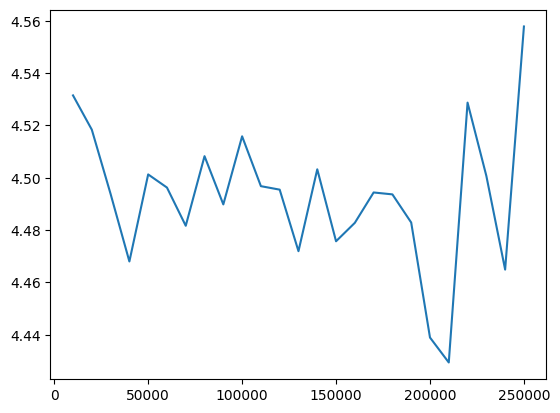

In [32]:
import matplotlib.pyplot as plt
plt.plot(training_curves(train_results_df)[0])

In [3]:
from ray import tune
from ray.air import session


def trainable(env_config: dict):
    # checkpoint_dir = tune.get_trial_dir()
    # print("checkpoint dir")

    train_config = (
        ppo.PPOConfig()
        .environment("evcharging", env_config=env_config)
        # .framework("tf2")
    )
    print("config created")
    algo = train_config.build(env="evcharging")
    print("algo built")
    for x in range(2):
        algo.train()
        algo.save(checkpoint_dir)

        env = get_env(full=False, real_trace=True, dp='Summer 2019', site='caltech', discrete=False, seed=True)()
        rllib_algo = RLLibAlgorithm(env, algo)
        reward_breakdown = rllib_algo.run(14).to_dict('list')

        session.report({
            **reward_breakdown, "final_eval": 0.0
        })
    
    env = get_env(full=False, real_trace=True, dp='Summer 2019', site='caltech', discrete=False, seed=True)()
    rllib_algo = RLLibAlgorithm(env, algo)
    reward_breakdown = rllib_algo.run(14).to_dict('list')
    session.report({
        reward_breakdown['reward']
    })


# a_param = tune.grid_search([2, 3])
# b_param = tune.grid_search([4, 5])

param_space = {
    "full": True,  # changes
    "real_trace": False,  # changes
    "dp": "Summer 2019",  # changes
    "site": "caltech",  # stay
    "discrete": False,  # stay
    "seed": 123
}

tuner = tune.Tuner(trainable, param_space=param_space)
results = tuner.fit()

2023-04-12 07:08:14,608	INFO worker.py:1553 -- Started a local Ray instance.


2023-04-12 07:08:21,696	ERROR tune.py:794 -- Trials did not complete: [trainable_cb9ed_00000]
2023-04-12 07:08:21,697	INFO tune.py:798 -- Total run time: 5.93 seconds (5.89 seconds for the tuning loop).
